In [1]:
# Import Pandas module
import pandas as pd

# Import NumPy module
import numpy as np

# The following line is a directive that tells matplotlib module to display
# generated graphs inline with the output of your code
%matplotlib inline 

# Import matplotlib module.  Matplotlib module allows us to generate graphs from data
import matplotlib.pyplot as plt

import geopandas as gpd


## What kind of data is this?
I found a data set from 311. 3-1-1 is a special telephone number supported in many communities in Canada and the United States. The number provides access to non-emergency municipal services.

In [2]:
df = pd.read_csv("311data.csv")

In [3]:
df.head()

,REQUEST_ID,CREATED_ON,REQUEST_TYPE,REQUEST_ORIGIN,STATUS,DEPARTMENT,NEIGHBORHOOD,COUNCIL_DISTRICT,WARD,TRACT,PUBLIC_WORKS_DIVISION,PLI_DIVISION,POLICE_ZONE,FIRE_ZONE,X,Y,GEO_ACCURACY
0,203364.0,2017-12-15T14:53:00,Street Obstruction/Closure,Call Center,1,DOMI - Permits,Central Northside,1.0,22.0,4.200322e+10,1.0,22.0,1.0,1-7,-80.016716,40.454144,EXACT
1,200800.0,2017-11-29T09:54:00,Graffiti,Control Panel,1,Police - Zones 1-6,South Side Flats,3.0,16.0,4.200316e+10,3.0,16.0,3.0,4-24,-79.969952,40.429243,APPROXIMATE
2,201310.0,2017-12-01T13:23:00,Litter,Call Center,1,DPW - Street Maintenance,Troy Hill,1.0,24.0,4.200324e+10,1.0,24.0,1.0,1-2,-79.985859,40.459716,EXACT
3,200171.0,2017-11-22T14:54:00,Water Main Break,Call Center,1,Pittsburgh Water and Sewer Authority,Banksville,2.0,20.0,4.200320e+10,5.0,20.0,6.0,4-9,-80.034210,40.406969,EXACT
4,193043.0,2017-10-12T12:46:00,Guide Rail,Call Center,1,DPW - Construction Division,East Hills,9.0,13.0,4.200313e+10,2.0,13.0,5.0,3-19,-79.876582,40.451226,EXACT


## Cleaning the Data
Fist I will begin by eliminating unnecessary columns. These columns are more for clerical work than pertain to location or type of violation.

In [4]:
df = df.drop(columns=['REQUEST_ID', 'REQUEST_ORIGIN', 'STATUS', 'COUNCIL_DISTRICT', 'PUBLIC_WORKS_DIVISION', 'PLI_DIVISION', 'POLICE_ZONE', 'FIRE_ZONE'])

In [5]:
df.describe()

,WARD,TRACT,X,Y
count,454050.000000,4.554500e+05,458346.000000,458346.000000
mean,16.425248,4.200323e+10,-79.473069,40.187318
std,8.024759,1.891662e+05,6.306500,3.189062
min,0.000000,4.200301e+10,-87.621300,0.000000
25%,10.000000,4.200311e+10,-80.007694,40.421220
50%,16.000000,4.200318e+10,-79.977746,40.443717
75%,22.000000,4.200328e+10,-79.935337,40.461700
max,32.000000,4.200398e+10,0.000000,41.885800


In [6]:
df.dtypes

CREATED_ON       object
REQUEST_TYPE     object
DEPARTMENT       object
NEIGHBORHOOD     object
WARD            float64
TRACT           float64
X               float64
Y               float64
GEO_ACCURACY     object
dtype: object

### Missing Values
There are a lot of missing vaues in this data set. Neighborhood has 40210 missing values. That is about 10% of the data points. Many of the data points that are missing neighborhood are also missing 'WARD', 'TRACT', 'X', and 'Y'. I will substitue the mode of the data for all of these missing values. The mode is brookline.

In [7]:
df['NEIGHBORHOOD'].value_counts()

Brookline               20386
Carrick                 19419
South Side Slopes       16176
Squirrel Hill South     16108
South Side Flats        14665
                        ...  
East Carnegie             455
Northview Heights         454
Glen Hazel                305
Arlington Heights          97
Mount Oliver Borough       59
Name: NEIGHBORHOOD, Length: 91, dtype: int64

In [8]:
df['NEIGHBORHOOD'] = df['NEIGHBORHOOD'].fillna(value = 'Brookline')

In [9]:
df.isnull().sum()

CREATED_ON          0
REQUEST_TYPE        0
DEPARTMENT       4317
NEIGHBORHOOD        0
WARD            40069
TRACT           38669
X               35773
Y               35773
GEO_ACCURACY        0
dtype: int64

There are no missing values for 'REQUEST_TYPE' which is the other column that I will be using.

In [10]:
qry = "NEIGHBORHOOD == True"
df.isnull().query(qry)

,CREATED_ON,REQUEST_TYPE,DEPARTMENT,NEIGHBORHOOD,WARD,TRACT,X,Y,GEO_ACCURACY


In [11]:
df['NEIGHBORHOOD'].value_counts()

Brookline               60596
Carrick                 19419
South Side Slopes       16176
Squirrel Hill South     16108
South Side Flats        14665
                        ...  
East Carnegie             455
Northview Heights         454
Glen Hazel                305
Arlington Heights          97
Mount Oliver Borough       59
Name: NEIGHBORHOOD, Length: 91, dtype: int64

Now I will divide the data by the maximum value to standardize all of the numbers from 0 to 1. Number close to 1 have the worst score, while numbers closer to 0 are the best.

In [12]:
df['NEIGHBORHOOD'].value_counts()/60596

Brookline               1.000000
Carrick                 0.320467
South Side Slopes       0.266948
Squirrel Hill South     0.265826
South Side Flats        0.242013
                          ...   
East Carnegie           0.007509
Northview Heights       0.007492
Glen Hazel              0.005033
Arlington Heights       0.001601
Mount Oliver Borough    0.000974
Name: NEIGHBORHOOD, Length: 91, dtype: float64

Now I wil get an idea for how the data is distributed. By making a historgram I see that it is highly right skewed. There are many neighborhoods with few calls and only a few neighborhoods with a lot of calls. It would be worth investigating what is causing all of these neighborhods to have such a high number of calls.

<AxesSubplot:>

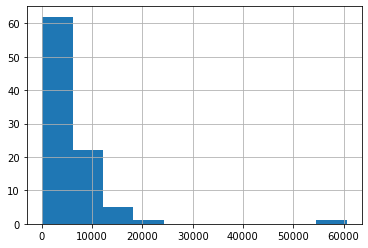

In [13]:
df['NEIGHBORHOOD'].value_counts().hist()

## Geopandas time

In [14]:
df_group = pd.DataFrame(df['NEIGHBORHOOD'].value_counts())
df_group.columns = ['#_of_Calls']
df_group.reset_index(inplace=True)
df_group.head()

,index,#_of_Calls
0,Brookline,60596
1,Carrick,19419
2,South Side Slopes,16176
3,Squirrel Hill South,16108
4,South Side Flats,14665


In [16]:
neighborhoods = gpd.read_file("Neighborhoods/Neighborhoods_.shp")
call_map = neighborhoods.merge(df_group, how='left', left_on='hood', right_on='index')
# look at the head to confirm it merged correctly
call_map[['hood','#_of_Calls','geometry']].head()

,hood,#_of_Calls,geometry
0,Central Oakland,6039,"POLYGON ((-79.95304 40.44203, -79.95302 40.442..."
1,North Oakland,4395,"POLYGON ((-79.95455 40.45882, -79.95427 40.458..."
2,West Oakland,2426,"POLYGON ((-79.96230 40.44294, -79.96220 40.442..."
3,Crawford-Roberts,3117,"POLYGON ((-79.98275 40.44641, -79.98273 40.446..."
4,Strip District,3610,"POLYGON ((-79.97494 40.45629, -79.97484 40.456..."


In [17]:
call_map.isnull().sum()

objectid      0
fid_blockg    1
statefp10     1
countyfp10    1
tractce10     1
blkgrpce10    1
geoid10       1
namelsad10    1
mtfcc10       1
funcstat10    1
aland10       1
awater10      1
intptlat10    1
intptlon10    1
shape_leng    1
fid_neighb    1
area          1
perimeter     1
neighbor_     1
neighbor_i    1
hood          0
hood_no       0
acres         1
sqmiles       1
dpwdiv        1
unique_id     1
sectors       0
shape_le_1    1
shape_ar_1    1
page_numbe    0
plannerass    0
created_us    0
created_da    0
last_edite    0
last_edi_1    0
Shape__Are    0
Shape__Len    0
geometry      0
index         0
#_of_Calls    0
dtype: int64

<AxesSubplot:>

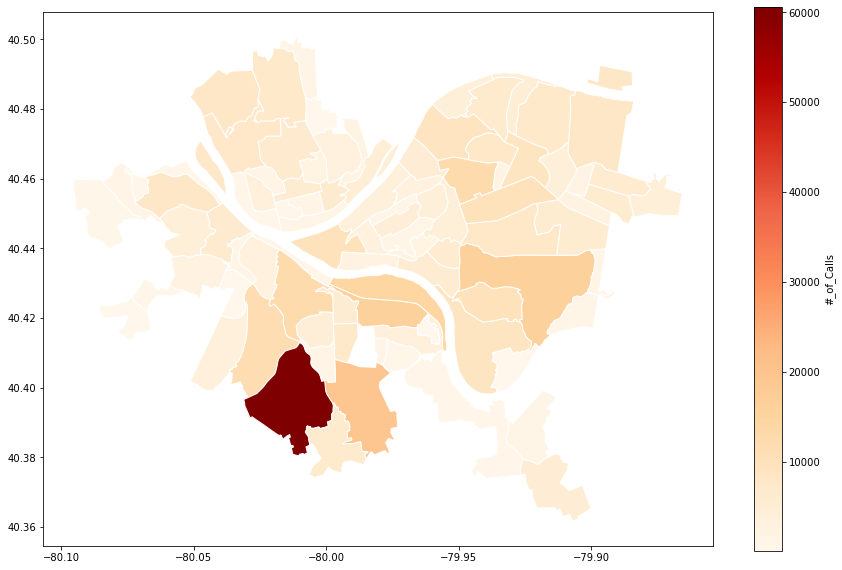

In [18]:
call_map.plot(column='#_of_Calls', # set the data to be used for coloring
               cmap='OrRd',              # choose a color palette
               edgecolor="white",        # outline the districts in white
               legend=True,              # show the legend
               legend_kwds={'label': "#_of_Calls"}, # label the legend
               figsize=(15, 10),         # set the size
               missing_kwds={"color": "lightgrey"} # set disctricts with no data to gray
               )

In [19]:
df1 = pd.DataFrame( {'Calls' : df['NEIGHBORHOOD'].value_counts().nsmallest(20)})
df1

,Calls
Mount Oliver Borough,59
Arlington Heights,97
Glen Hazel,305
Northview Heights,454
East Carnegie,455
Ridgemont,522
Chartiers City,608
St. Clair,680
Fairywood,799
Hays,823


In [20]:
df_scores = pd.DataFrame( {'Calls' : df['NEIGHBORHOOD'].value_counts()/60596})
df_scores.nsmallest(20, columns= 'Calls')

,Calls
Mount Oliver Borough,0.000974
Arlington Heights,0.001601
Glen Hazel,0.005033
Northview Heights,0.007492
East Carnegie,0.007509
Ridgemont,0.008614
Chartiers City,0.010034
St. Clair,0.011222
Fairywood,0.013186
Hays,0.013582


In [21]:
df2 = pd.DataFrame( {'rank' : [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]} )

In [22]:
df1.reset_index(inplace=True)

In [23]:
df1

,index,Calls
0,Mount Oliver Borough,59
1,Arlington Heights,97
2,Glen Hazel,305
3,Northview Heights,454
4,East Carnegie,455
5,Ridgemont,522
6,Chartiers City,608
7,St. Clair,680
8,Fairywood,799
9,Hays,823


In [24]:
df3 = pd.DataFrame({'Neighborhood' : df1['index'], 'rank' : df2['rank']})

In [25]:
df3.head(20)

,Neighborhood,rank
0,Mount Oliver Borough,1
1,Arlington Heights,2
2,Glen Hazel,3
3,Northview Heights,4
4,East Carnegie,5
5,Ridgemont,6
6,Chartiers City,7
7,St. Clair,8
8,Fairywood,9
9,Hays,10


## Results
I normalized the score fo the neighborhoods by dividing by the max. Then I took the 20 smallest number of calls to make a readable graph.

<AxesSubplot:title={'center':'20 PGH neighborhoods with the lowest number of 311 Calls'}, xlabel='Neighborhood', ylabel='# of Calls'>

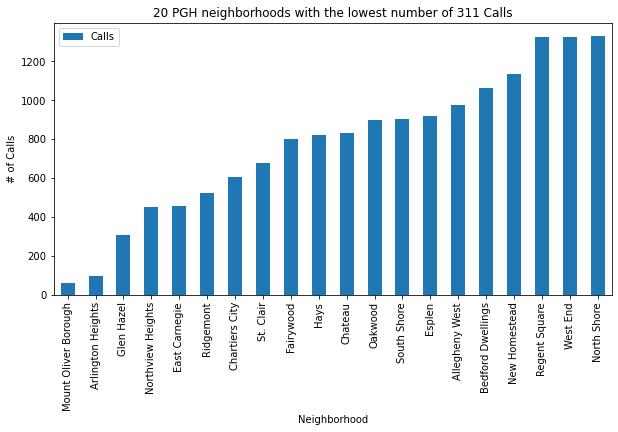

In [26]:


df1.plot(x = 'index',
         kind = 'bar',
         xlabel = 'Neighborhood',
         ylabel = '# of Calls',
         title = '20 PGH neighborhoods with the lowest number of 311 Calls',
         figsize = (10,5))


## Conclusion
Based on this data, Mt. Oliver Borough is the best Pittsburgh neighborhood. It clearly has the least amount of 311 calls as represented numerically, with geopandas, and in the bar graph.

---

## <center> PLI Violations Found in Pittsburgh Neighborhoods </center>

---

### Background

For one of our criteias for the "Best Neighborhood in Pittsburgh", we decided to see how many PLI violations were detected in each neighborhood. In the city of Pittsburgh, there is a department named the Department of Permits, Licenses and Inspections Code Enforcemnt that strives to regulate and protect the "health, safety and welfare in existing buildings and structures" (https://pittsburghpa.gov/pli/pli-code-enforcement). Also according to the website, it states that some offenses that are considered PLI violations are:

- Sidewalks that are considered tripping hazards
- Electrical, building and/or zoning violations
- Debris on property
- Issues caused by animals
- Sewage problems

Since the metric of ranking the "Best Neighborhood in Pittsburgh" we are using is finding the neighborhood with the least amount of offenses or crimes, we think that using the PLI violations dataset would be a beneficial tool to help us come to a conclusion for our ranking. A neighborhood with low occurrences of these violations would signify that the area for the most part is abiding by the rules and regulations that the city of Pittsburgh tries to uphold. This would definitely help narrow down the options for finding a neighborhood worthy enough to be considered the best in Pittsburgh.

**The dataset that we will be using has data spanning from 2015 to 2020.**

---

### Working with the Data

In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import geopandas
import matplotlib.pyplot as plt # Importing the neccesssary libraries to be able to work with the data and plot the graphs

pli_violations = pd.read_csv("pli_violations_data.csv") # Importing the data from the .csv file

Before we begin to work with the data, let's inspect the details of the dataset and see what information is given to us.

In [2]:
pli_violations.info() # Looking at the type of data in each column

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53123 entries, 0 to 53122
Data columns (total 20 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   STREET_NUM             53110 non-null  float64
 1   STREET_NAME            53123 non-null  object 
 2   INSPECTION_DATE        53123 non-null  object 
 3   CASE_NUMBER            53123 non-null  object 
 4   INSPECTION_RESULT      53123 non-null  object 
 5   DPW_REQUEST            2098 non-null   object 
 6   VIOLATION              53123 non-null  object 
 7   LOCATION               53123 non-null  object 
 8   CORRECTIVE_ACTION      53123 non-null  object 
 9   PARCEL                 53123 non-null  object 
 10  NEIGHBORHOOD           53066 non-null  object 
 11  COUNCIL_DISTRICT       53069 non-null  float64
 12  WARD                   53069 non-null  float64
 13  TRACT                  53069 non-null  float64
 14  PUBLIC_WORKS_DIVISION  53069 non-null  float64
 15  PL

In [3]:
len(pli_violations) # How many reports there are in the data

53123

Based on the data, we can see that there are **53,123** total reported violations. This is a lot of data to sift through! Also, there are two important columns that are present in the dataset, **"INSPECTION_RESULT"** and **"NEIGHBORHOOD"**. Let's keep these columns in mind when we look at the data. Let's see what the data actually looks like and what kind of results we get.

In [4]:
pli_violations.head() # Showing the first 5 rows of data to see what the data looks like

,STREET_NUM,STREET_NAME,INSPECTION_DATE,CASE_NUMBER,INSPECTION_RESULT,DPW_REQUEST,VIOLATION,LOCATION,CORRECTIVE_ACTION,PARCEL,NEIGHBORHOOD,COUNCIL_DISTRICT,WARD,TRACT,PUBLIC_WORKS_DIVISION,PLI_DIVISION,POLICE_ZONE,FIRE_ZONE,X,Y
0,7809.0,SUSQUEHANNA ST,2016-08-09,O-787281,Violations Found,NaN,2003 IPMC 301.3 Vacant structures and land :: ...,Secure Property :: Cut and clear all overgrowt...,301.3 Vacant structures and land. All vacant s...,0175G00080000000,Homewood South,9.0,13.0,130400.0,2.0,13.0,5.0,3-17,-79.888578,40.449926
1,249.0,E MEYERS AVE,2017-01-23,O-786866,Violations Found,NaN,2003 IPMC 302.4 Weeds :: 2003 IPMC 307.1 Accum...,Throughout property :: Throughout property :: ...,Overgrown throughout property. Cut all overgro...,0060H00150000000,Carrick,4.0,29.0,290200.0,4.0,29.0,3.0,4-12,-79.983902,40.401018
2,225.0,FIFTH AVE,2017-07-28,O-1052529,Abated,NaN,2003 IFC 107.2.1 Test and inspection records,3 PNC PLACE 225 FIFTH AVE,Failure to maintain annual fire alarm inspecti...,0001D0017300AH00,Central Business District,6.0,2.0,20100.0,6.0,2.0,2.0,1-3,-80.001301,40.441294
3,264.0,PLYMOUTH ST,2017-06-23,O-1048951,Abated,NaN,2003 IPMC 302.8 Motor vehicles :: 2003 IPMC 30...,2 inoperative vehicles in the rear :: Overgrow...,no inoperative or unlicensed motor vehicle sha...,0006R00250000000,Duquesne Heights,2.0,19.0,191100.0,5.0,19.0,3.0,4-1,-80.021747,40.434457
4,2205.0,BERNARD ST,2016-11-15,O-947319,Abated,NaN,City Code 922.02 - Occupancy Permits,Rear of property,Apply for occupancy permit for rear deck.Apply...,0096R00094000000,Overbrook,4.0,32.0,320700.0,4.0,32.0,3.0,4-25,-80.005387,40.386590


In the column **"INSPECTION_RESULT"**, we can see two different results from just the first 5 pieces of data in the dataset, "Violations Found" and "Abated". "Abated" means that the report was considered to be not significant enough to be concluded as a violation, so we will remove these from the dataset. But first, let's make sure if there are any other results besides the two that were previously mentioned.

In [5]:
pli_violations['INSPECTION_RESULT'].unique()

array(['Violations Found', 'Abated', 'Voided'], dtype=object)

Besides the two previously mentioned results, we see that there is a third one, "Voided". "Voided" and "Abated" will be removed from the dataset, as we are only concerned with the reported instances that actually had violations that were discovered. 

In [6]:
violations_found_mask =  pli_violations['INSPECTION_RESULT'] == "Violations Found" # Creating a query mask that only looks at reported violations that actually had violations found
violations_found_data = pli_violations[violations_found_mask]
violations_found_data.head()   # The first 5 rows of the new dataset

,STREET_NUM,STREET_NAME,INSPECTION_DATE,CASE_NUMBER,INSPECTION_RESULT,DPW_REQUEST,VIOLATION,LOCATION,CORRECTIVE_ACTION,PARCEL,NEIGHBORHOOD,COUNCIL_DISTRICT,WARD,TRACT,PUBLIC_WORKS_DIVISION,PLI_DIVISION,POLICE_ZONE,FIRE_ZONE,X,Y
0,7809.0,SUSQUEHANNA ST,2016-08-09,O-787281,Violations Found,NaN,2003 IPMC 301.3 Vacant structures and land :: ...,Secure Property :: Cut and clear all overgrowt...,301.3 Vacant structures and land. All vacant s...,0175G00080000000,Homewood South,9.0,13.0,130400.0,2.0,13.0,5.0,3-17,-79.888578,40.449926
1,249.0,E MEYERS AVE,2017-01-23,O-786866,Violations Found,NaN,2003 IPMC 302.4 Weeds :: 2003 IPMC 307.1 Accum...,Throughout property :: Throughout property :: ...,Overgrown throughout property. Cut all overgro...,0060H00150000000,Carrick,4.0,29.0,290200.0,4.0,29.0,3.0,4-12,-79.983902,40.401018
6,1321.0,JEFFERS ST,2017-01-10,O-902559,Violations Found,NaN,2003 IPMC 302.4 Weeds,ALL EXTERIOR PROPERTY MUST BE FREE FROM WEEDS ...,CUT AND CLEAN OVERGROWTH,0042N00313000000,Sheraden,2.0,20.0,202200.0,5.0,20.0,6.0,1-16,-80.065058,40.453192
11,1014.0,ABDELL ST,2016-07-06,O-794377,Violations Found,NaN,2003 IPMC 301.3 Vacant structures and land :: ...,VACANT UNSECURE STRUCTURE :: FRONT PORCH :: RO...,ALL VACANT STRUCTURES SHALL BE MAINTAINED IN A...,0007D00010000000,Manchester,6.0,21.0,210700.0,1.0,21.0,1.0,1-8,-80.019911,40.452682
13,117.0,EILER AVE,2016-07-19,O-784815,Violations Found,NaN,2003 IPMC 301.3 Vacant structures and land :: ...,Doors :: Windows :: Rear porch :: Front porch ...,Doors are broken and building is not secured. ...,0095H00289000000,Carrick,4.0,29.0,290200.0,4.0,29.0,3.0,4-12,-79.984552,40.391541


When comparing to the previous dataset, we can now see that the "Abated" violations are removed from the dataset. Now that the dataset only shows instances of violations that were actually found, let's insure that there are no null values in either the **"INSPECTION_RESULT"** or **"NEIGHBORHOOD"** columns.

In [7]:
adjusted_data_set = violations_found_data.dropna(subset = ['INSPECTION_RESULT', 'NEIGHBORHOOD'])    # Method found on https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.dropna.html    

Now that we have our final data that only shows violations that were found with no null values in the two previously mentioned columns, let's see the amount of reports we are now working with

In [8]:
len(adjusted_data_set)

16840

In [10]:
len(pli_violations) - len(adjusted_data_set) # The amount of reports from the first dataset minus the amount of reports from the new dataset, which equals the amount of reports removed in the new dataset

36283

The new dataset now has **16,840** reports that had discovered violations. The query mask has significantly reduced the amount of reports present in the dataset (from the calculation above, **36,283** entries were removed). Let's also see how many neighborhoods and which neighborhoods we're working with

In [11]:
adjusted_data_set['NEIGHBORHOOD'].unique()   # What neighborhoods we are working with

array(['Homewood South', 'Carrick', 'Sheraden', 'Manchester',
       'Squirrel Hill South', 'Middle Hill', 'Bloomfield',
       'South Side Flats', 'Homewood North', 'Allentown', 'Elliott',
       'Garfield', 'Troy Hill', 'Mt. Oliver', 'Lincoln Place', 'Oakwood',
       'Hazelwood', 'Brookline', 'Fineview', 'Arlington', 'Beechview',
       'Upper Hill', 'Marshall-Shadeland', 'Knoxville', 'South Oakland',
       'Mount Washington', 'East Allegheny', 'Lincoln-Lemington-Belmar',
       'Beltzhoover', 'Esplen', 'Bedford Dwellings',
       'Spring Hill-City View', 'Central Northside', 'Perry South',
       'Windgap', 'Friendship', 'Squirrel Hill North', 'Homewood West',
       'East Liberty', 'Crawford-Roberts', 'Upper Lawrenceville',
       'Perry North', 'Spring Garden', 'North Oakland', 'Chartiers City',
       'Central Lawrenceville', 'Central Oakland', 'South Side Slopes',
       'Polish Hill', 'Crafton Heights', 'Greenfield', 'Bluff',
       'St. Clair', 'Brighton Heights', 'Duquesne 

In [12]:
len(adjusted_data_set['NEIGHBORHOOD'].unique())   # To see how many total neighborhoods we are working with

90

---

### Graphing the Data (Part 1: Visualizing the Data)

For this dataset, we've decided to graph the data using a bar graph, as it is easier to see visually how each neighborhood compares in terms of how many violations have been reported and found in each area. The X-axis will comprise of each of the neighborhoods in the dataset and the Y-axis will be the amount of violations that have occurred in each of these neighborhoods.

Text(0, 0.5, 'Amount of Violations Found')

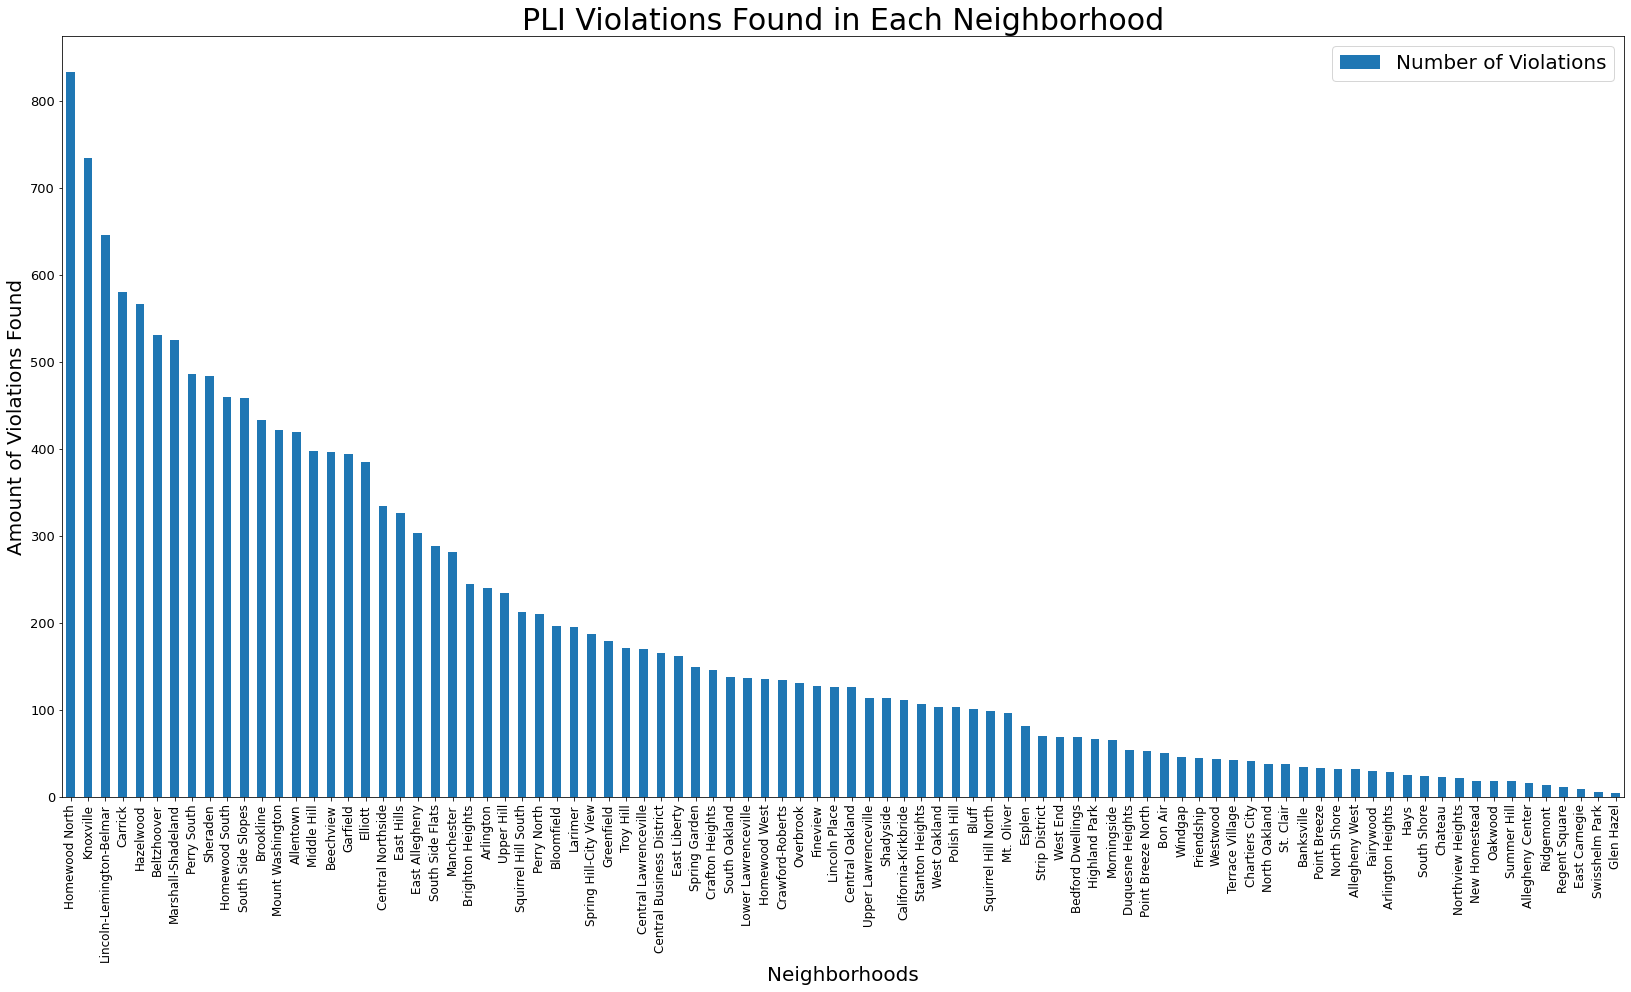

In [13]:
adjusted_data_set['NEIGHBORHOOD'].value_counts().plot.bar(figsize =(28,14)) # Creating a bar graph with each bar signifying how many 
plt.title("PLI Violations Found in Each Neighborhood", size = 30) # Adding a title to the graph and adjusting the size of it
plt.xlabel("Neighborhoods", size = 20)    # Labeling the X-axis and adjusting the size of the label
plt.legend(['Number of Violations'], prop = {'size': 20})      # Creating a legend (size adjustment found: https://stackoverflow.com/questions/7125009/how-to-change-legend-size-with-matplotlib-pyplot)
plt.xticks(size = 12)  # Adjusting the size of all of the X-axis ticks
plt.yticks(size = 13) # Adjusting the size of all of the Y-axis ticks
plt.ylabel("Amount of Violations Found", size = 20) # Labeling the Y-axis and adjusting the size of the label


From the looks of the graph, we can see which neighborhoods have an abundance of violations that were found. The graph seems very cluttered due to the amount of "values" in the X-axis. Because of the high instances of violations found in the neighborhoods that are located at the left of the graph, we can assume that these would not be contenders for the "Best Neighborhood in Pittsburgh", so we will remove them from the graph and focus on the ones with lower instances. For the new data, we will only focus on the neighborhoods that are located to the right of **Crafton Heights** on the graph.

In [14]:
(adjusted_data_set['NEIGHBORHOOD'] == "Crafton Heights").value_counts() # This is to see how many times Crafton Heights has appeared in the dataset

False    16694
True       146
Name: NEIGHBORHOOD, dtype: int64

We now see that the neighborhood of **Crafton Heights** has had **146** seperate instances of violations found in the neighborhood. With this number, we will now find out how many neighborhoods have less than 146 instances of violations.

In [15]:
(adjusted_data_set['NEIGHBORHOOD'].value_counts() < 146).value_counts() # Counting how many neighborhoods have below 146 instances of violations found

True     52
False    38
Name: NEIGHBORHOOD, dtype: int64

We now know that **52** of the **90** total neighborhoods in the dataset have below 146 instances of violations that were found. We will now only graph those neighborhoods and remove the other **38** from the set to make the graph easier to read.

Text(0, 0.5, 'Amount of Violations Found')

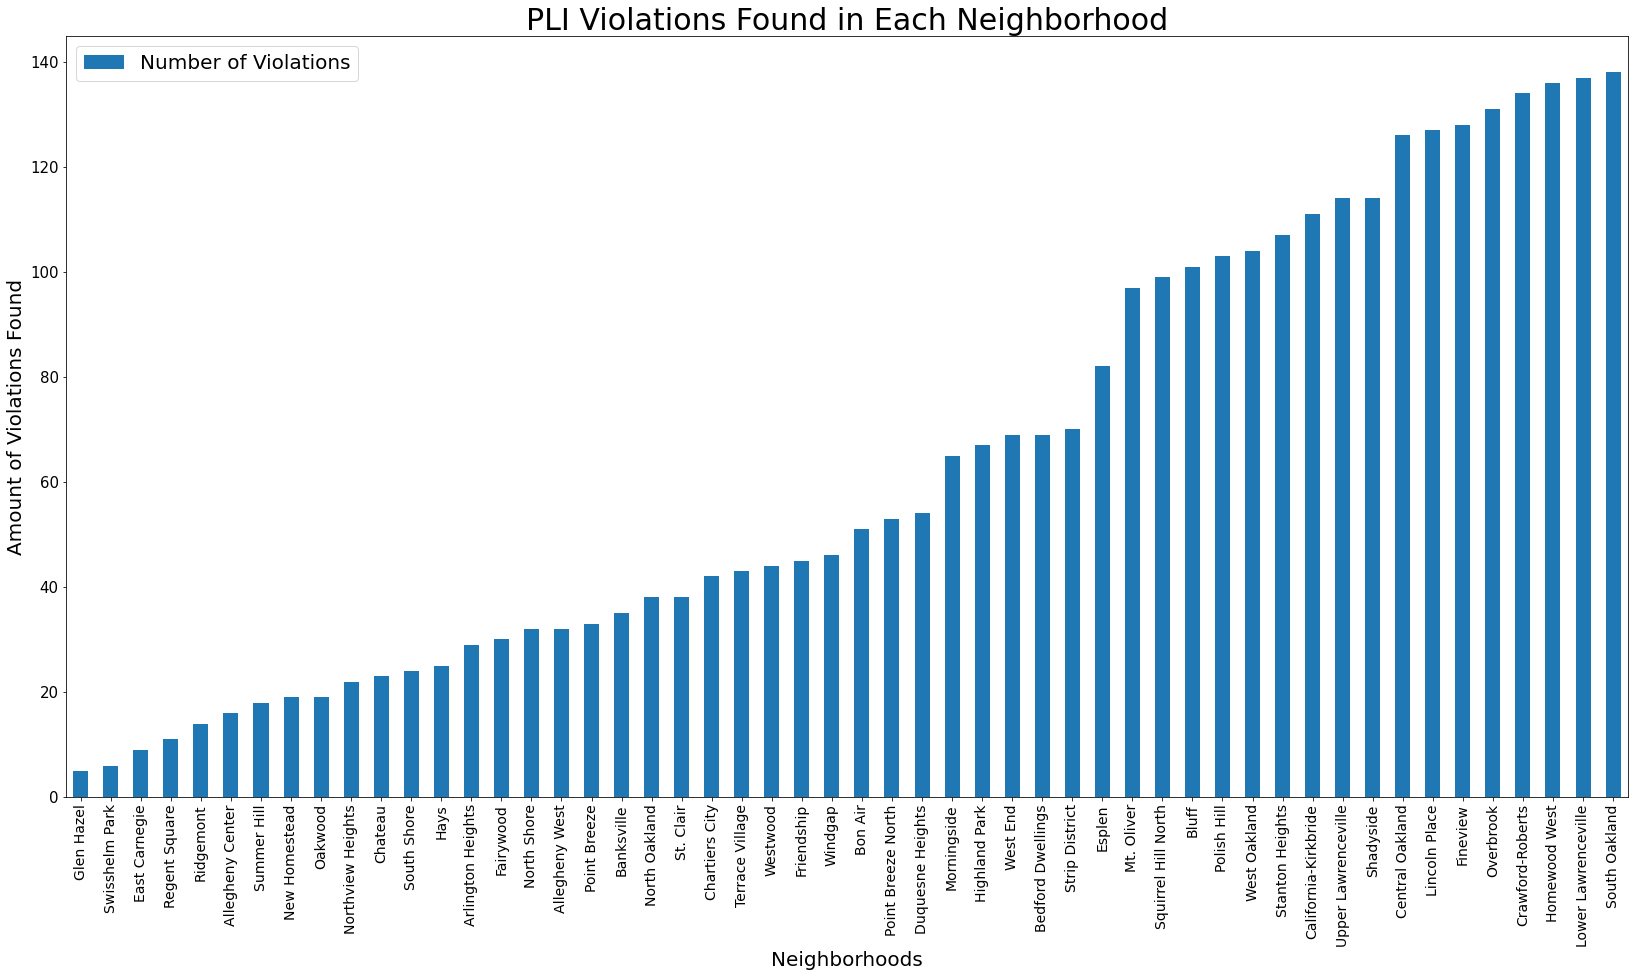

In [16]:
smallest_violations = pd.DataFrame({"Number of Violations" : adjusted_data_set["NEIGHBORHOOD"].value_counts().nsmallest(52)}) # Graphing the 52 smallest neighborhoods in the dataset
smallest_violations.plot.bar(figsize =(28,14))
plt.title("PLI Violations Found in Each Neighborhood", size = 30)
plt.xlabel("Neighborhoods", size = 20)                               # Identical to the first graph that was plotted
plt.xticks(size = 14) 
plt.yticks(size = 15)
plt.legend(prop = {'size': 20})
plt.ylabel("Amount of Violations Found", size = 20) 

Because the new graph just removed 38 values from the X-axis (including the outliers), the bar graph is now much easier to read. For the next section, we will now primarily focus on the top twenty neighborhoods with the least amount of violations

---

### Graphing the Data (Part 2: Top Twenty Neighborhoods)

We will now graph the top twenty neighborhoods that have the least amount of PLI violations and create a table showing each of the neighborhoods in the top twenty with the amount of PLI violations found.

Text(0, 0.5, 'Amount of Violations Found')

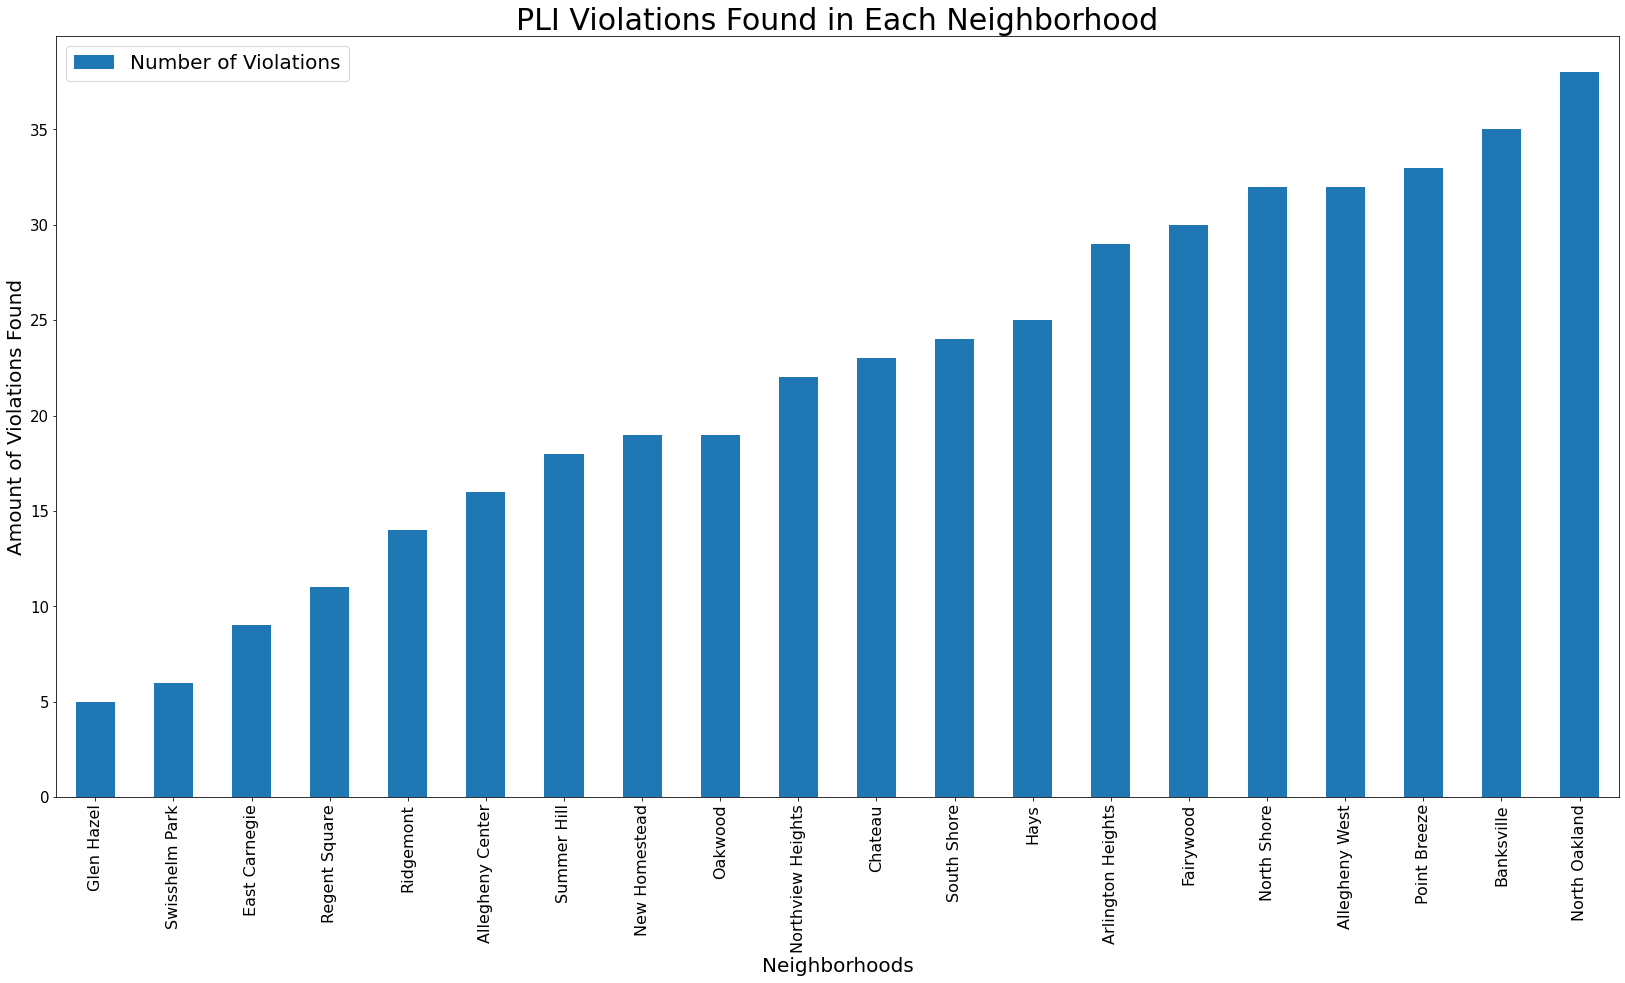

In [17]:
top_twenty_smallest = pd.DataFrame({"Number of Violations" : adjusted_data_set["NEIGHBORHOOD"].value_counts().nsmallest(20)}) # Graphing the 20 neighborhoods in the dataset with the lowest amout of PLI violations
top_twenty_smallest.plot.bar(figsize =(28,14))
plt.title("PLI Violations Found in Each Neighborhood", size = 30)
plt.xlabel("Neighborhoods", size = 20)                               # Identical to the first and second graph that I plotted before
plt.xticks(size = 16)
plt.yticks(size = 15)
plt.legend(prop = {'size': 20})
plt.ylabel("Amount of Violations Found", size = 20) 

In [18]:
pli = pd.DataFrame( {"Number of Violations" : adjusted_data_set['NEIGHBORHOOD'].value_counts().nsmallest(20)})
pli.reset_index(inplace=True)  # Resetting index to easily merge the data for conclusion
pli

,index,Number of Violations
0,Glen Hazel,5
1,Swisshelm Park,6
2,East Carnegie,9
3,Regent Square,11
4,Ridgemont,14
5,Allegheny Center,16
6,Summer Hill,18
7,New Homestead,19
8,Oakwood,19
9,Northview Heights,22


The graph and table above show the ten neighborhoods with the lowest amount of violations found. Now, we will calculate the percentage of PLI violations each neighborhood had contributed to the total amount found, which was **16,840**. This will be important later to calculate the metric for the "Best Neighborhood in Pittsburgh".

In [19]:
pli_scores = pd.DataFrame( {'Percentage of Violations' : adjusted_data_set['NEIGHBORHOOD'].value_counts()/16840})  # Calculating the percentage of PLI violations for each neighborhood
pli_scores.reset_index(inplace=True)
pli_scores.nsmallest(20, columns = 'Percentage of Violations')

,index,Percentage of Violations
89,Glen Hazel,0.000297
88,Swisshelm Park,0.000356
87,East Carnegie,0.000534
86,Regent Square,0.000653
85,Ridgemont,0.000831
84,Allegheny Center,0.000950
83,Summer Hill,0.001069
81,New Homestead,0.001128
82,Oakwood,0.001128
80,Northview Heights,0.001306


In [20]:
rank = pd.DataFrame( {'Rank' : [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]}) # Creating a rank dataframe to rank the neighborhoods

In [21]:
ranked_list = pd.DataFrame({'Neighborhood' : pli['index'], 'Rank' : rank['Rank'], 'Number of Violations' : pli['Number of Violations']})    # Merge to better visualize best neighborhoods
ranked_list

,Neighborhood,Rank,Number of Violations
0,Glen Hazel,1,5
1,Swisshelm Park,2,6
2,East Carnegie,3,9
3,Regent Square,4,11
4,Ridgemont,5,14
5,Allegheny Center,6,16
6,Summer Hill,7,18
7,New Homestead,8,19
8,Oakwood,9,19
9,Northview Heights,10,22


---

### Graphing the Data (Part 3: GeoPandas)

We now have visualized all of the data (more specifically, a graph that shows every neighborhood and the amount of PLI violations that were found, a graph that has removed the neighborhoods with an abundance of violations found as these should not be contenders for the "Best Neighborhood in Pittsburgh", and also the top twenty neighborhoods that would be strong contenders for the title). Now, we will visualize the graph using GeoPandas. Rather than reading off a list of neighborhoods with the amount of violations they have, it will be much easier for people to comprehend the information through this visualizaiton.

In [22]:
neighborhoods = geopandas.read_file("Neighborhoods/Neighborhoods_.shp")  # Calling in the neighborhood files to be able to plot the map

In [23]:
violations_geo = pd.DataFrame({"Number of Violations" : adjusted_data_set["NEIGHBORHOOD"].value_counts()})  # Dataset for the GeoPandas plot
violations_geo.reset_index(inplace=True)
violations_geo

,index,Number of Violations
0,Homewood North,833
1,Knoxville,735
2,Lincoln-Lemington-Belmar,646
3,Carrick,580
4,Hazelwood,567
...,...,...
85,Ridgemont,14
86,Regent Square,11
87,East Carnegie,9
88,Swisshelm Park,6


In [24]:
violations_map = neighborhoods.merge(violations_geo, how='inner', left_on='hood', right_on='index') # Merging the sets and seeing if it was done correctly
violations_map[['hood','Number of Violations','geometry']].head()  # Checking to see if its ready to be plotted

,hood,Number of Violations,geometry
0,Central Oakland,126,"POLYGON ((-79.95304 40.44203, -79.95302 40.442..."
1,North Oakland,38,"POLYGON ((-79.95455 40.45882, -79.95427 40.458..."
2,West Oakland,104,"POLYGON ((-79.96230 40.44294, -79.96220 40.442..."
3,Crawford-Roberts,134,"POLYGON ((-79.98275 40.44641, -79.98273 40.446..."
4,Strip District,70,"POLYGON ((-79.97494 40.45629, -79.97484 40.456..."


Text(0.5, 1.0, 'Map of PLI Violations in Pittsburgh Neighborhoods')

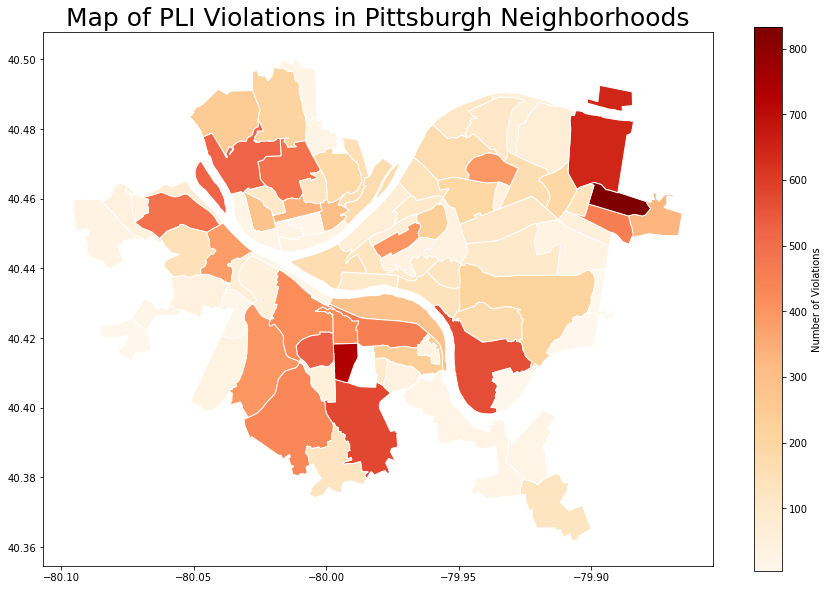

In [25]:
violations_map.plot(column = 'Number of Violations',                      # Assigning the data for the map
                   cmap = 'OrRd',                                         # Color scheme of the map
                   edgecolor = "white",                                   # Setting the edge colors to white
                   legend = True,                                         # Displaying the legend
                   legend_kwds = {'label': 'Number of Violations'},       # Adding a label
                   figsize = (15,10),                                     # Adjusting size of map
                   missing_kwds = {"color": "lightgrey"})                 # Accounting for missing neighborhoods, assigning them the color lightgrey
plt.title("Map of PLI Violations in Pittsburgh Neighborhoods", size = 25) # Adding a title to the map

---

### Conclusion


Based on this dataset of PLI violations in the Pittsburgh neighborhood, the best contender for the title of "Best Neighborhood in Pittsburgh" is **Glen Hazel**, with a total of 5 PLI violations that were found. We can assume that from the data, the people of **Glen Hazel** for the most part abide by the regulations and laws implemented by the the city of Pittsburgh. Although the neighborhood placed in rank 1, it wasn't necessarily a landslide victory. The neighborhoods placed in ranks 1 - 5 scored very close to one another. It would be hard to find the "Best Neighborhood in Pittsburgh" by using just the PLI violations, but this dataset definitely helped narrow down the possible contenders for the title. When we combine all three datasets, the answer of will be much more clear.